In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


class Pips(object):
    def __init__(self, cellgps, rules, dominos):
        self.cell_rules = self.make_cells_dict(cellgps)
        self.rules = {**rules, **{'Z': ['true']}}
        self.dominos = {(min(i,j), max(i,j)) for i,j in dominos}
        self.tiling_scenarios = self.get_tilepos_combos({*self.cell_rules})
        self.solutions = None

    def do_solve(self):
        """
        Find all possible solutions using recursive search.
        """
        tiles = {i for i in self.dominos}
        placement = {i: None for i in sorted({*sum(self.tiling_scenarios, [])})}
        self.solutions = self.find_solutions(placement, tiles)

    @staticmethod
    def make_cells_dict(cellgps):
        """
        Get dict of cell positions -> related rule ID
        """
        return {(i, j): c
                for i, r in enumerate([k for k in cellgps.split('\n') if k]) 
                for j, c in enumerate(list(r)) 
                if r and c != '.'}

    @staticmethod
    def get_tilepos_combos(cells, tilepos=None):
        """
        Get list of possible ways to tile all cells with 1*2 tiles.
        """
        if tilepos is None:
            tilepos = [((i, j), k) 
                       for i, j in cells
                       for k in[(i+1, j), (i, j+1)] 
                       if k in cells]
        return [[i]+j 
                for i in tilepos 
                if min(cells) in i and all([k >= min(cells) for k in i])
                for j in Pips.get_tilepos_combos(cells - {*i}, tilepos)] if cells else [[]]

    def find_solutions(self, placement, tiles):
        """
        Recursion step: Identify cell with fewest possible tiles that can be placed there,
        and initialize branch for each.
        """
        if tiles:
            # List of cells with values already set
            cell_values = {i:j for k,v in placement.items() if v for i,j in zip(k, v)}
            
            # All possible values in each cell
            cell_val_poss = {k:v 
                             for rule in self.rules
                             for k,v in self.get_poss_combos(rule, cell_values, tiles).items()
                             if k not in cell_values}
            if any([len(i)==0 for i in cell_val_poss.values()]):
                return []
            
            # All possible tile placements in each tiling scenario
            poss_bysc = [z 
                         for i in self.tiling_scenarios 
                         if all([sum([k in cell_values for k in j])!=1 for j in i])
                         for z in[{j: {k[::l]
                                       for k in tiles
                                       for l in([1] if len({*k})<2 else [1, -1])
                                       if all([y in cell_val_poss[j[x]] for x,y in enumerate(k[::l])])
                                       and (self.cell_rules[j[0]] != self.cell_rules[j[1]] 
                                            or [] not in self.get_poss_combos(self.cell_rules[j[0]], 
                                                                              {**cell_values, **dict(zip(j, k[::l]))}, 
                                                                              tiles-{k}).values())}
                                   for j in i
                                   if j[0] not in cell_values}]
                         if all([len(m)>0 for m in z.values()])]
    
            # All possible tile placements for each cell
            poss_tilepos = {pos for sc in poss_bysc for pos in sc}
            poss_bycell = {cell: [(pos, tv) 
                                  for pos in poss_tilepos if cell in pos
                                  for tv in {tv for sc in poss_bysc for tv in sc.get(pos, [])}]
                           for cell in {*self.cell_rules.keys()}-{*cell_values.keys()}}
            
            # Find cell with minimum possible placements.  End branch if any have none.
            minposs = min([len(i) for i in poss_bycell.values()])
            if minposs == 0:
                return []
        
            # Next iteration for each possible placement
            return [solution
                    for pos, tv in [v for k,v in poss_bycell.items() if len(v) == minposs][0]
                    for solution in self.find_solutions({**{j: {pos: tv}.get(j) 
                                                            for i in poss_bysc if pos in i 
                                                            for j in i}, 
                                                         **{k:v 
                                                            for k,v in placement.items() if v}}, 
                                                        tiles - {tv, tv[::-1]})]
        else:
            return [placement]

    def get_poss_combos(self, rule, cell_values, tiles):
        """
        Get list of possible values for cells bound by specified rule,
        accounting for "known" cell values and available remaining tiles
        """
        rulecells = [k for k,v in self.cell_rules.items() if v==rule]
        cells = [[cell_values[i]] if i in cell_values else [*range(7)] 
                for i in rulecells]
        ruletype, param = (self.rules[rule]+[None])[:2]
        vals = [*[j for i in tiles for j in i],
                *[cell_values[i] for i in {*rulecells}&{*cell_values}]]
        tile_valcts = [vals.count(i) for i in range(7)]
    
        poss_combos = dict(zip(rulecells, 
                           [sorted({*i}) 
                            for i in zip(*[c for c in self.get_poss_combos_inner(cells, ruletype, param)
                                           if all([j<=k 
                                                   for j,k in zip([c.count(i) for i in range(7)], 
                                                                   tile_valcts)])])]))
        return poss_combos or {k: [] for k in rulecells}

    @staticmethod
    def get_poss_combos_inner(cells, ruletype, param, tsum=0, tvals=None):
        """
        Inner loop for get_poss_combos function - list cell value combinations
        for specified rule.
        """
        if cells:
            return [[i]+j
                    for i in cells[0]
                    for j in Pips.get_poss_combos_inner(cells[1:], 
                                                        ruletype, 
                                                        param, 
                                                        tsum+i, 
                                                        (tvals or [])+[i])]
        else:
            return ([[]] 
                    if (ruletype == 'sum' and tsum==param)
                    or (ruletype == 'sum_lt' and tsum < param)
                    or (ruletype == 'sum_gt' and tsum > param)
                    or (ruletype == 'all_eq' and len({*tvals})==1)
                    or (ruletype == 'all_ne' and len({*tvals})==len(tvals))
                    or (ruletype == 'true')
                    else [])

    def show_solutions(self, n=10):
        """
        Graphically display each solution in input list
        """
        if self.solutions is None:
            print("Run do_solve() method first!")
        else:
            for snum, solution in enumerate(self.solutions[:n]):
                sol_img = np.ones([(max(i)+2)*38+1 
                                   for i in zip(*[j for i in self.solutions[0] for j in i])]+[4], 
                                  dtype=np.float32)    
                for i in range(0, sol_img.shape[0], 38):
                    sol_img[max(i-1,0):i+2, :] = [[[i/255 for i in [218, 233, 248, 255]]]]
                for i in range(0, sol_img.shape[1], 38):
                    sol_img[:, max(i-1,0):i+2] = [[[i/255 for i in [218, 233, 248, 255]]]]
                for pos in solution:
                    tile_img = mpimg.imread('../data/domino_base.png')
                    tile_img[5:32, 6:33] = mpimg.imread(f'../data/domino_{solution[pos][0]}.png')
                    tile_img[5:32, -33:-6] = mpimg.imread(f'../data/domino_{solution[pos][1]}.png')
                    if pos[0][0] != pos[1][0]:
                        tile_img = np.transpose(tile_img, (1, 0, 2))
                    sol_img[(y:=pos[0][0]*38+1): y+tile_img.shape[0], (x:=pos[0][1]*38+1): x+tile_img.shape[1]] = tile_img
                print(f'Solution #{snum+1} of {len(self.solutions)}')
                plt.imshow(sol_img)
                plt.show()

    @classmethod
    def solve(cls, cellgps, rules, dominos):
        """
        Solve Pips!
    
        Inputs:
            - cellgps - String, describing layout of game board with:
                  '.' for out-of-bounds cells, 
                  'Z' for cells not bound by rules
                  'A'-'Y' for cells bound by rules (one letter for each rule)
            - rules - Dict, of {ruleID: [ruletype, param (optional)]}, defining constraints 
                      for corresponding cells i.e. cells with matching letter ID in cellgps.
                      Permitted values for ruletype are:
                      'sum' - Cell values sum to param value exactly
                      'sum_gt' - Cell values sum to > param value
                      'sum_lt' - Cell values sum to < param value
                      'all_eq' - Cell values are all equal (no param needed)
                      'all_ne' - Cell values are all different (no param needed)
            - dominos - List of tuples; dominos to place into game board.
    
        Example:
            cellgps = '''
            ...........
            .Z.ABBZCCZ.
            .DDDB..E...
            ..F.BBGGGG.
            ..H.I....J.
            ..K.ILLJJJ.
            ...........
            '''
    
            rules = {
                'A': ['sum', 2],
                'B': ['sum', 26],
                'C': ['sum', 12],
                'D': ['all_ne'],
                'E': ['sum', 1],
                'F': ['sum', 4],
                'G': ['all_eq'],
                'H': ['sum_gt', 4],
                'I': ['sum', 0],
                'J': ['sum', 4],
                'K': ['sum', 0],
                'L': ['sum', 6],
            }
    
            dominos = [(5, 5), (6, 0), (4, 2), (5, 2), (3, 0), 
                       (1, 4), (0, 5), (4, 0), (2, 0), (2, 2), 
                       (1, 6), (5, 1), (1, 2), (4, 6), (1, 1)]    
        """
        obj = cls(cellgps, rules, dominos)
        obj.do_solve()
        obj.show_solutions()

Solution #1 of 1


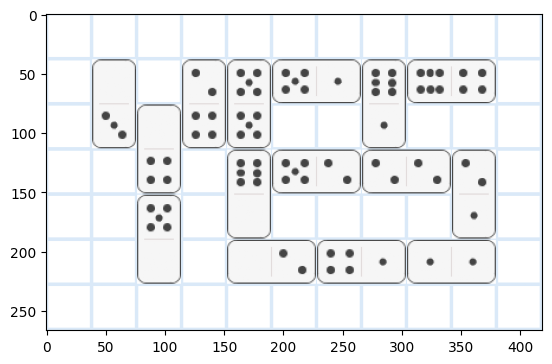

In [2]:
cellgps = """
...........
.Z.ABBZCCZ.
.DDDB..E...
..F.BBGGGG.
..H.I....J.
..K.ILLJJJ.
...........
"""
rules = {
    'A': ['sum', 2],
    'B': ['sum', 26],
    'C': ['sum', 12],
    'D': ['all_ne'],
    'E': ['sum', 1],
    'F': ['sum', 4],
    'G': ['all_eq'],
    'H': ['sum_gt', 4],
    'I': ['sum', 0],
    'J': ['sum', 4],
    'K': ['sum', 0],
    'L': ['sum', 6],
}
dominos = [(5, 5), (6, 0), (4, 2), (5, 2), (3, 0), (1, 4), (0, 5), (4, 0), (2, 0), (2, 2), (1, 6), (5, 1), (1, 2), (4, 6), (1, 1)]

Pips.solve(cellgps, rules, dominos)

Solution #1 of 1


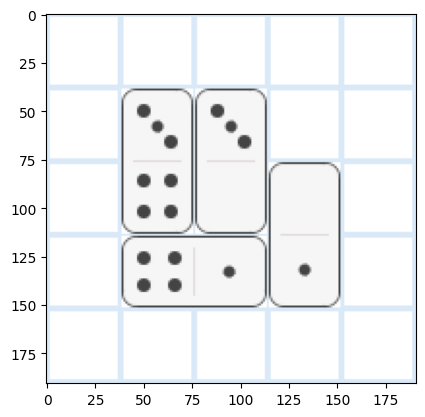

In [3]:
cellgps = """
...........
.AA........
.BCC.......
.BDD.......
...........
...........
...........
"""
rules = {
    'A': ['sum', 6],
    'B': ['sum', 8],
    'C': ['sum', 0],
    'D': ['sum', 2],
}
dominos = [(1, 4), (0, 3), (4, 3), (1, 0)]

Pips.solve(cellgps, rules, dominos)

Solution #1 of 1


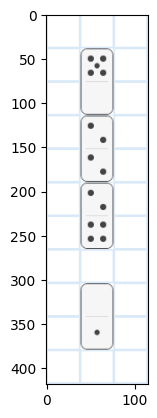

In [ ]:
cellgps = """
...........
.A.........
.Z.........
.B.........
.B.........
.B.........
.C.........
...........
.Z.........
.D.........
...........
"""
rules = {
    'A': ['sum', 5],
    'B': ['all_eq'],
    'C': ['sum_lt', 5],
    'D': ['sum', 1],
}
dominos = [(2, 2), (5, 0), (1, 0), (4, 2)]

Pips.solve(cellgps, rules, dominos)

Solution #1 of 396


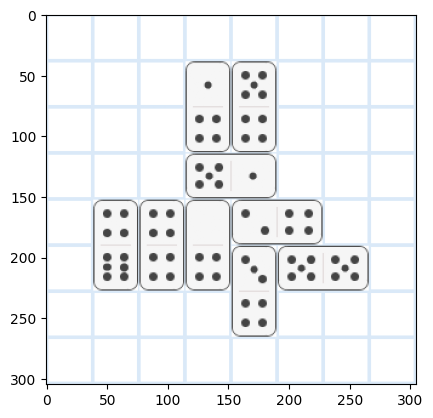

Solution #2 of 396


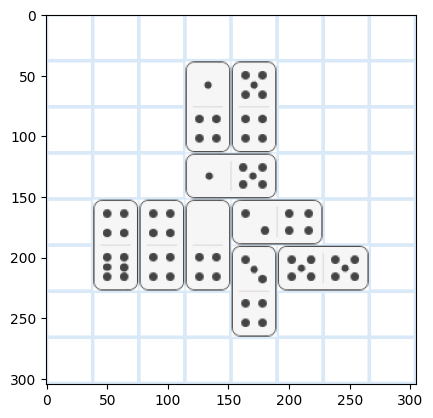

Solution #3 of 396


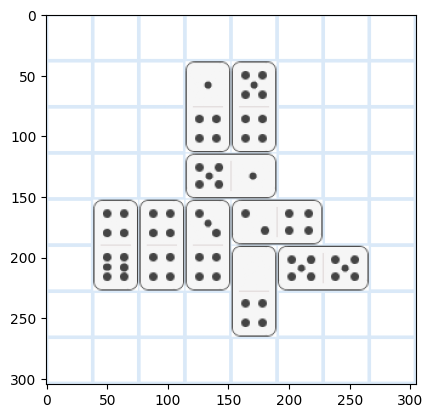

Solution #4 of 396


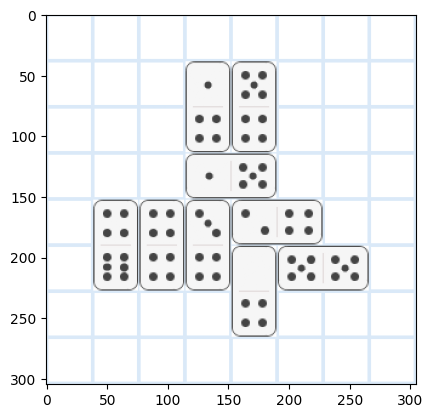

Solution #5 of 396


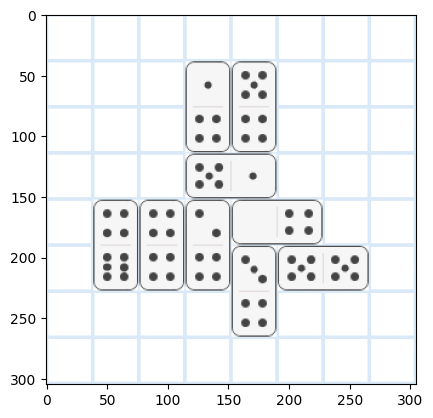

Solution #6 of 396


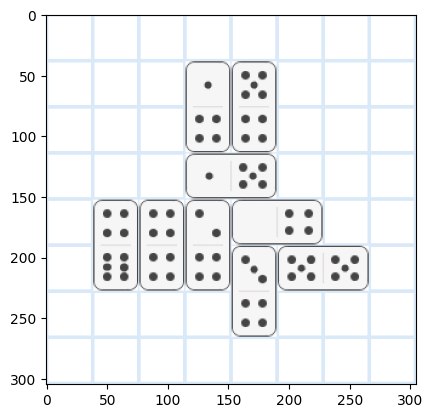

Solution #7 of 396


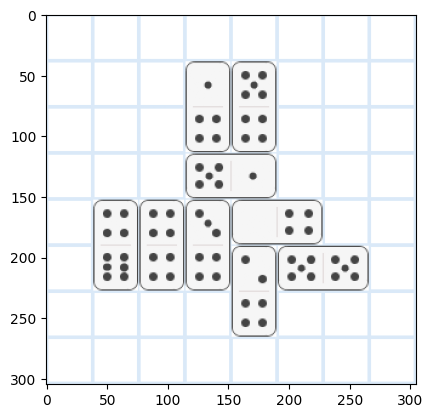

Solution #8 of 396


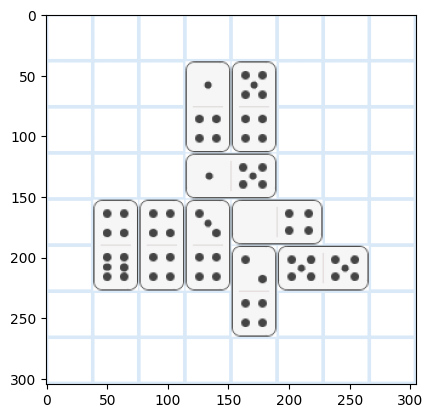

Solution #9 of 396


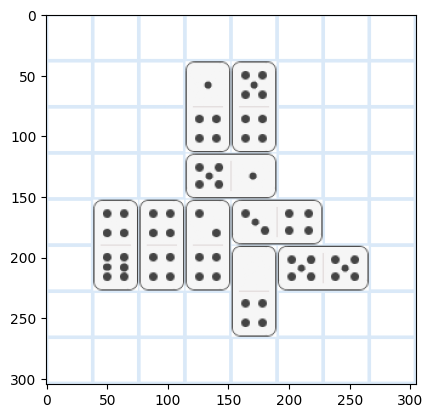

Solution #10 of 396


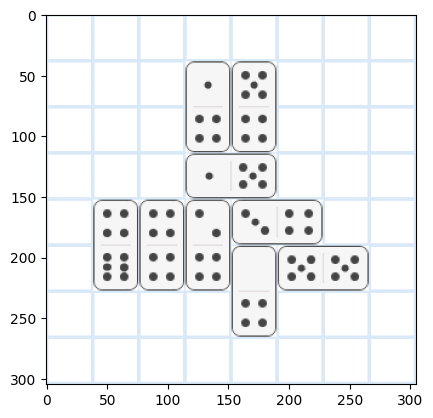

In [11]:
cellgps = """
...........
...AB......
...CC......
...DD......
.EEDDF.....
.GEEDHH....
....I......
...........
"""
rules = {
    'A': ['sum', 1],
    'B': ['sum', 5],
    'C': ['all_eq'],
    'D': ['all_ne'],
    'E': ['all_eq'],
    'F': ['sum', 4],
    'G': ['sum', 6],
    'H': ['sum', 10],
    'I': ['sum', 4],
}
dominos = [(0, 4), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (5, 1), (6, 4), (5, 5)]

Pips.solve(cellgps, rules, dominos)

Solution #1 of 1


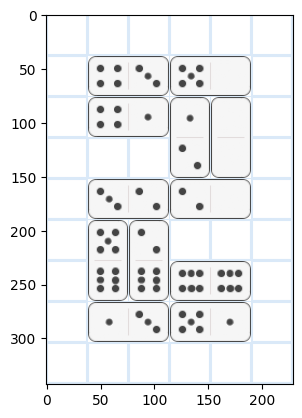

In [12]:
cellgps = """
...........
.AZZB......
.ACCB......
...DB......
.ZDDB......
.ZD........
.EEEE......
.FGHZ......
...........
"""
rules = {
    'A': ['all_eq'],
    'B': ['sum', 0],
    'C': ['sum', 2],
    'D': ['all_eq'],
    'E': ['all_eq'],
    'F': ['sum_lt', 3],
    'G': ['sum_lt', 4],
    'H': ['sum_gt', 4],
}
dominos = [(6, 2), (5, 0), (3, 1), (5, 6), (3, 2), (2, 1), (3, 4), (1, 5), (2, 0), (4, 1), (0, 0), (6, 6)]

Pips.solve(cellgps, rules, dominos)